In [53]:
import pandas as pd
import torch
from torch import nn
from torch import optim
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.init import xavier_uniform_
from sklearn.model_selection import train_test_split
import seaborn as sns

sns.set_theme()


#not sure which one is necessary
np.random.seed(42)
torch.manual_seed(42)

In [54]:

df_train = pd.read_csv('./data/train.csv')

book_ids = df_train['book_id'].unique()
user_ids = df_train['user_id'].unique()

n_books = len(book_ids)
n_users = len(user_ids)

#unique index for each user and book in the matrix
book_idx = {ids: i for i,ids in enumerate(book_ids)}
user_idx = {ids: i for i,ids in enumerate(user_ids)}

### whole df to train on once optimal hyperparameters are found

#to access vectors in MF
user_assigned_idx = torch.LongTensor(np.array([user_idx[i] for i in df_train['user_id'].values]))
book_assigned_idx = torch.LongTensor(np.array([book_idx[i] for i in df_train['book_id'].values]))

# to compute training loss
ratings = torch.FloatTensor(df_train['rating'].values)

In [55]:
#train-val split for hyperparam selection
df_train['user_idx'] = df_train['user_id'].map(user_idx)
df_train['book_idx'] = df_train['book_id'].map(book_idx)

train_data, val_data = train_test_split(df_train, test_size=0.2, random_state=42)

user_assigned_idx_train = torch.LongTensor(train_data['user_idx'].values)
book_assigned_idx_train = torch.LongTensor(train_data['book_idx'].values)
ratings_train = torch.FloatTensor(train_data['rating'].values)

user_assigned_idx_val = torch.LongTensor(val_data['user_idx'].values)
book_assigned_idx_val = torch.LongTensor(val_data['book_idx'].values)
ratings_val = torch.FloatTensor(val_data['rating'].values)




In [56]:
class MatrixFactorization(torch.nn.Module):
    def __init__(self, n_users, n_books, embedding_size, var, init):
        """
        Initializes a MatrixFactorization model
        P contains the embedded vectors of users
        Q contains the embedded vectors of books

        input:
            n_users: int, number of users
            n_books: int, number of books
            embeddsing_size: int, dimension of embedded space
            var: float, range of initialized weights (for random or uniform initialization)
            init: string, type of method to initialize weights, must be in {uniform, normal xavier}, keeps initialization from nn.Embeding otherwise
        """


        super().__init__()
        self.P = nn.Embedding(n_users, embedding_size)
        self.Q = nn.Embedding(n_books, embedding_size)

        #change weights initialization:

        if init == 'uniform':
            self.P.weight.data.uniform_(-var, var)
            self.Q.weight.data.uniform_(-var, var)

        if init == 'normal':
            self.P.weight.data.normal_(mean=0, std=var)
            self.Q.weight.data.normal_(mean=0, std=var)

        if init == 'xavier':
            xavier_uniform_(self.P.weight)
            xavier_uniform_(self.Q.weight)


        
    def forward(self, user_id, book_id):
        """
        Forward pass to predict ratings

        inputs:
            user_id: tensor, ids of user
            book_id: tensor, ids of books
        ouput:
            out: tensor, predicted ratings of (user, book) pairs
        """

        user_vec = self.P(user_id)
        book_vec = self.Q(book_id)
        #dot product
        out = (user_vec*book_vec).sum(1)
        return out


    


In [57]:
"""
To tune:
embedding size
weights init
n_epoch
learning rate
weight decay
add reg in loss?
clipping final ratings to 0.5, 1, 1.5, ... (juste pour meilleure method)


plots:
loss vs embedding size with uniform(sqrt(1/d)) avec le reste constant
loss over epoch du meilleur model
"""

"""
current best:
N_EPOCH = 1000
embedding_size = 200
var = 0.01 (uniform)
lr = 1e-4
decay = 1e-5
lambda_ = 0 (no reg)
"""

'\ncurrent best:\nN_EPOCH = 1000\nembedding_size = 200\nvar = 0.01 (uniform)\nlr = 1e-4\ndecay = 1e-5\nlambda_ = 0 (no reg)\n'

In [58]:

#metric
mse = torch.nn.MSELoss()

def train(user_assigned_idx, book_assigned_idx, ratings, embedding_size, var, init, decay, lr, N_EPOCH, verbose):
    model = MatrixFactorization(n_users, n_books, embedding_size, var, init)

    #weight decay acts as a l2 regularizer
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
    mse = torch.nn.MSELoss()

    model.train()

    for epoch in range(N_EPOCH):

        optimizer.zero_grad()
        r_hat = model(user_assigned_idx, book_assigned_idx)
        #ratings must be between 0 and 5
        r_hat_clipped = torch.clamp(r_hat, 0, 5)


        loss = mse(r_hat_clipped, ratings)
        rmse = torch.sqrt(loss)

        loss.backward()
        optimizer.step()
        if epoch % 100 == 0 and verbose:
            print(f'epoch {epoch}, RMSE: {rmse.item()}')

    return model


def validation(model, user_assigned_idx_val, book_assigned_idx_val, ratings):
    model.eval()
    r_hat = model(user_assigned_idx_val, book_assigned_idx_val)
    r_hat_clipped = torch.clamp(r_hat, 0, 5)

    err = mse(r_hat_clipped, ratings)
    rmse = torch.sqrt(err)

    return rmse.item()




epoch 0, RMSE: 2.596252202987671
epoch 100, RMSE: 2.57143497467041
epoch 200, RMSE: 2.5398805141448975
epoch 300, RMSE: 2.4985787868499756
epoch 400, RMSE: 2.4459924697875977
epoch 500, RMSE: 2.3817989826202393
epoch 600, RMSE: 2.3065614700317383
epoch 700, RMSE: 2.2218685150146484
epoch 800, RMSE: 2.129906415939331
epoch 900, RMSE: 2.0327868461608887


epoch 0, RMSE: 2.599592685699463
epoch 100, RMSE: 2.563488006591797
epoch 200, RMSE: 2.5123343467712402
epoch 300, RMSE: 2.4391071796417236
epoch 400, RMSE: 2.341365098953247
epoch 500, RMSE: 2.220301628112793
epoch 600, RMSE: 2.0804436206817627
epoch 700, RMSE: 1.9277409315109253
epoch 800, RMSE: 1.7689648866653442
epoch 900, RMSE: 1.6132069826126099


epoch 0, RMSE: 2.601154088973999
epoch 100, RMSE: 2.555783271789551
epoch 200, RMSE: 2.4860219955444336
epoch 300, RMSE: 2.381027936935425
epoch 400, RMSE: 2.2391982078552246
epoch 500, RMSE: 2.066253900527954
epoch 600, RMSE: 1.872330904006958
epoch 700, RMSE: 1.6706422567367554
epoch 8

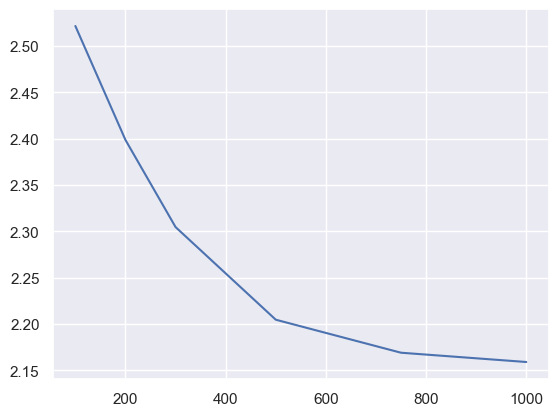

In [59]:
N_EPOCH = 1000
embedding_size = 200
var = 0.01
lr = 1e-4
decay = 1e-5
init = 'uniform'
verbose = False

ds = [100, 200, 300, 500, 750, 1000]
losses = np.zeros(len(ds))
for i,d in enumerate(ds):
    var = 1/np.sqrt(d)
    print(d)
    model = train(user_assigned_idx_train, book_assigned_idx_train, ratings_train, d, var, init, decay, lr, N_EPOCH, verbose)
    if verbose:
        print('\n')
    losses[i] = validation(model, user_assigned_idx_val, book_assigned_idx_val, ratings_val)
    print(losses[i])


plt.plot(ds, losses)


In [60]:

def write_submission(model, df_test):
    """
    Writes and return a csv file containing the predicted rating for the Kaggle competition

    input:
        model: trained MatrixFactorization object
        df_test: pandas dataframe containing the (user, book) pairs we want to predict

    output:
        submission: pandas dataframe, predicted ratings
    """


    #put model in evaluating mode as training is done
    model.eval()

    #all users and book are already in train.csv -> no cold start problem
    test_user_assigned_idx = torch.LongTensor(np.array([user_idx[i] for i in df_test['user_id'].values]))
    test_book_assigned_idx = torch.LongTensor(np.array([book_idx[i] for i in df_test['book_id'].values]))


    predicted_ratings = model(test_user_assigned_idx, test_book_assigned_idx)

    predicted_ratings_clipped = torch.clamp(predicted_ratings, 0, 5)
    #cast in list for saving
    final = [rating.item() for rating  in predicted_ratings_clipped]


    submission = pd.DataFrame({
            'id':range(len(df_test)),
            'rating': final
        })

    submission.to_csv('./submission.csv', index=False)

    return submission


df_test = pd.read_csv('./data/test.csv')

submission = write_submission(model, df_test)

submission


,id,rating
0,0,1.495319
1,1,0.994038
2,2,0.592192
3,3,0.290173
4,4,1.004382
...,...,...
29362,29362,0.907549
29363,29363,0.369746
29364,29364,0.934928
29365,29365,0.502379
